In [741]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string
import random
from collections import Counter
import sys
%matplotlib inline

# Our City

These are constants that define the behaviour of the city - 

In [742]:
CITY_POPULATION = 10000
MEAN_NETWORK_DEGREE = 50
MEAN_INTERACTIONS_PER_DAY = 20


The city is modeled as a small-world network graph (https://en.wikipedia.org/wiki/Small-world_network)

The graph is generated using the Watts–Strogatz model (https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model)

In [743]:
BETA = 0.5 # a parameter for the model - read wiki page

In [744]:

city_social_network = nx.watts_strogatz_graph(CITY_POPULATION, MEAN_NETWORK_DEGREE, BETA)


<BarContainer object of 33 artists>

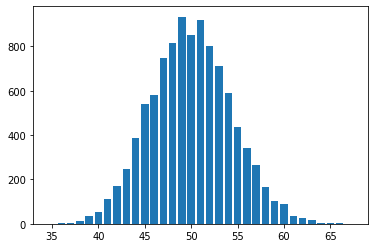

In [745]:
degrees = dict(city_social_network.degree()).values()
degree_counts = np.unique(list(degrees), return_counts = True)
degree_counts
plt.bar(degree_counts[0], degree_counts[1]) 


Generating an Age probability distribution function-

Based on 2000 Census data (https://www.census.gov/prod/cen2010/briefs/c2010br-03.pdf)

In [ ]:
TRANSMISSION_RATE = 1.0/100
ILLNESS_LENGTH_DAYS = 14
SYMPTOMATIC_RATE = 0.5

In [746]:
age_group_numbers_USA = [19175798,20549505,20528072,20219890,18964001,19381336,20510388,22706664,22441863, 20092404,17585548,13469237, 10805447,9533545,8857441,7415813,4945367,2789818,1112531,286784,50454,]

Each age group is of 5 years - under 5yo, 5-10, 10-15 .... 95-100, >100

For convenience, we choose a representative age for each group

<BarContainer object of 21 artists>

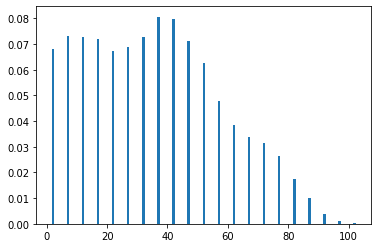

In [747]:
age_group_ratios = np.array(age_group_numbers_USA)/sum(age_group_numbers_USA)
ages = [2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97, 102]
plt.bar(ages, age_group_ratios)

Assigning an age to each person in our city

In [748]:
city_ages = np.random.choice(ages, CITY_POPULATION, p = age_group_ratios)

<BarContainer object of 21 artists>

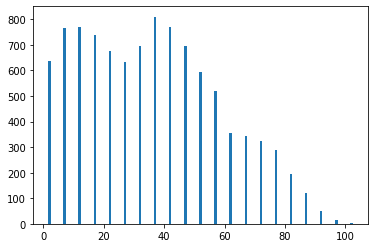

In [749]:
age_dist = np.unique(city_ages, return_counts = True)
plt.bar(age_dist[0], age_dist[1])

In [750]:
for i in range(CITY_POPULATION):
    city_social_network.nodes[i]['age'] = city_ages[i]
    city_social_network.nodes[i]['infected'] = False
    city_social_network.nodes[i]['alive'] = True
    city_social_network.nodes[i]['isolated'] = False
    city_social_network.nodes[i]['infected_date'] = sys.maxsize
    city_social_network.nodes[i]['recovered'] = False
    
    

In [751]:
city_social_network.nodes[0]

{'age': 62,
 'infected': False,
 'alive': True,
 'isolated': False,
 'infected_date': 9223372036854775807,
 'recovered': False}

In [752]:
def mortality_pdf(age):
    return 0.3
    return ((age-102)/1020 +0.1)

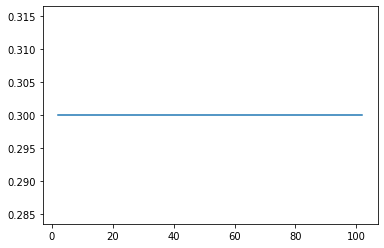

In [753]:
plt.plot(ages,[mortality_pdf(age) for age in ages])

In [754]:
def get_disease_stats(city_graph):
    total_infected = 0
    total_dead = 0
    total_healthy = 0
    total_recovered = 0
    for i in city_graph.nodes():
        if not city_social_network.nodes[i]['alive']:
            total_dead+=1
        #dead people are not infected
        elif city_social_network.nodes[i]['infected']:
            total_infected +=1
        elif city_social_network.nodes[i]['recovered']:
            total_recovered +=1
        
        else:
            total_healthy+=1
        
    return{'infected':total_infected, 'dead': total_dead, 'never infected':total_healthy, 'recovered': total_recovered}
        
        

In [755]:
get_disease_stats(city_social_network)

{'infected': 0, 'dead': 0, 'never infected': 10000, 'recovered': 0}

In [756]:
def get_daily_visits_no_preventative_measures(city_graph):
    total_visits_in_day = (len(city_graph.nodes)*MEAN_INTERACTIONS_PER_DAY)/2 # Two people take part in an interaction
    day_visits = random.sample(list(city_graph.edges), int(total_visits_in_day))
    return day_visits
    

Distribution of Interactions on Day 0 (by person):

In [757]:
day_0_interactions = get_daily_visits(city_social_network)
interactions_per_person = Counter()
for interaction in day_0_interactions:
    interactions_per_person[interaction[0]]+=1
    interactions_per_person[interaction[1]]++1
    

<BarContainer object of 25 artists>

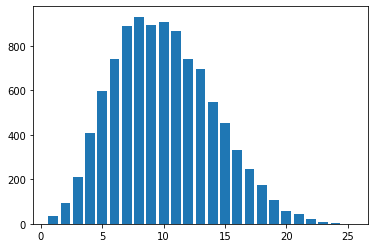

In [758]:
hist = np.unique(list(interactions_per_person.values()), return_counts = True)
plt.bar(hist[0],hist[1])

In [761]:

def simulate_single_day(city_graph, day_number):
    
    interactions = get_daily_visits_no_preventative_measures(city_graph)
    
    for p1,p2 in interactions:
        if not city_graph.nodes[p1]['alive'] or not city_graph.nodes[p1]['alive']:
            continue
        if city_graph.nodes[p1]['infected'] and city_graph.nodes[p2]['infected']:
            continue
        if city_graph.nodes[p1]['recovered'] or city_graph.nodes[p2]['recovered']:
            continue
        if not city_graph.nodes[p1]['infected'] and not city_graph.nodes[p2]['infected']:
            continue
        # one of the people is infected.
        if random.uniform(0, 1) < TRANSMISSION_RATE:
            #infect!
            if not city_graph.nodes[p1]['infected']:
                
                city_graph.nodes[p1]['infected'] = True
                city_graph.nodes[p1]['infected_date'] = day_number
            else:
                
                city_graph.nodes[p2]['infected'] = True
                city_graph.nodes[p2]['infected_date'] = day_number
    for p in city_graph.nodes():
        if day_number - city_graph.nodes[p]['infected_date'] == ILLNESS_LENGTH_DAYS:
            if random.uniform(0, 1) < mortality_pdf(city_graph.nodes[p]['age']) :
                city_graph.nodes[p]['alive'] = False
            else:
                city_graph.nodes[p]['recovered'] = True
                city_graph.nodes[p]['infected'] = False
  

In [762]:
daily_stats = []
city_social_network.nodes[0]['infected'] = True
city_social_network.nodes[0]['infected_date'] = 0
total_infections = 1
day=0
while total_infections>0:
    
    simulate_single_day(city_social_network,day)
    daily_stats.append(get_disease_stats(city_social_network))
    if day%10==0:
        print('day:'+str(day))
        print(daily_stats[-1])
    total_infections = daily_stats[-1]['infected']
    day+=1

day:0
{'infected': 3, 'dead': 0, 'never infected': 9997, 'recovered': 0}
day:10
{'infected': 12, 'dead': 0, 'never infected': 9988, 'recovered': 0}
day:20
{'infected': 74, 'dead': 2, 'never infected': 9922, 'recovered': 2}
day:30
{'infected': 372, 'dead': 13, 'never infected': 9594, 'recovered': 21}
day:40
{'infected': 1682, 'dead': 62, 'never infected': 8098, 'recovered': 158}
day:50
{'infected': 4595, 'dead': 315, 'never infected': 4342, 'recovered': 748}
day:60
{'infected': 4557, 'dead': 1180, 'never infected': 1456, 'recovered': 2807}
day:70
{'infected': 1717, 'dead': 2301, 'never infected': 616, 'recovered': 5366}
day:80
{'infected': 403, 'dead': 2741, 'never infected': 388, 'recovered': 6468}
day:90
{'infected': 181, 'dead': 2843, 'never infected': 276, 'recovered': 6700}
day:100
{'infected': 107, 'dead': 2889, 'never infected': 211, 'recovered': 6793}
day:110
{'infected': 56, 'dead': 2915, 'never infected': 171, 'recovered': 6858}
day:120
{'infected': 63, 'dead': 2929, 'never in

In [763]:
def plot_infection_progression(daily_stats):
    df = pd.DataFrame(daily_stats)
    colors = [[0.5,0.5,0.5], [0.6,0,0], [0,0.5,0],[0,0.75,0] ] # grey, red, light green, dark green
    df.plot(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    
    df.plot.area(y = ['dead', 'infected', 'recovered', 'never infected'], color = colors)
    plt.show()
  

    

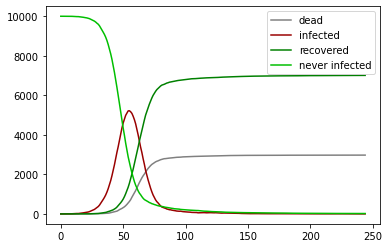

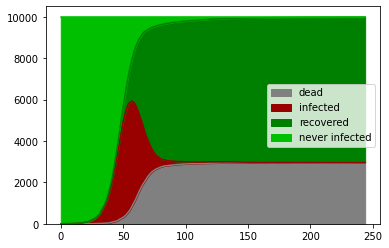

In [764]:
plot_infection_progression(daily_stats)